In [ ]:
%pip install pandas datasets scikit-learn xgboost joblib numpy transformers torch tqdm matplotlib

In [ ]:
import pandas as pd
from datasets import Dataset
import json
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
import joblib
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim import AdamW
import matplotlib.pyplot as plt

d:\project_NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Предобработка перед разметкой

In [2]:
data = pd.read_csv('разметка комментариев 2.csv')

In [18]:
filtered_data = data.copy()
filtered_data['comment'] = filtered_data['comment'].str.replace(r'[^\w\s]', '', regex=True)
filtered_data['comment'] = filtered_data['comment'].str.replace(r'\s+', ' ', regex=True)
filtered_data['comment'] = filtered_data['comment'].str.strip()
filtered_data['comment'] = filtered_data['comment'].str.lower()
filtered_data = filtered_data[filtered_data['comment'].str.len() > 5]

comment_counts = filtered_data['comment'].value_counts()
duplicates_more_than_3 = comment_counts[comment_counts > 3]
duplicates_more_than_3

comment
спасибо                              347
спасибо за оперативность              69
спасибо большое                       66
благодарю                             25
оперативно                            24
отлично                               22
большое спасибо                       15
быстро                                13
благодарю за оперативность            12
огромное спасибо                      12
спасибо большое за оперативность      11
оперативно спасибо                    10
спасибо огромное                       9
молодцы                                9
все отлично                            9
спасибо оперативно                     8
все отлично спасибо                    7
супер спасибо                          6
очень оперативно                       6
отлично спасибо                        6
отличный мастер                        6
всё отлично                            5
спасибо за консультацию                5
все хорошо                             5
все ок  

In [19]:
filtered_data

,id,rating,comment,Нравится скорость отработки заявок,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Понравилось выполнение заявки,Вопрос решен
0,2945792,5,спасибо,NaN,NaN,NaN,NaN,NaN
1,3234340,5,спасибо,NaN,NaN,NaN,NaN,NaN
2,3380332,5,отлично,NaN,NaN,NaN,NaN,NaN
3,3381812,5,благодарю за оперативное решение проблемы,NaN,NaN,NaN,NaN,NaN
4,3461991,5,прекрасный специалист побольше таких,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2368,3507812,5,долго но приятно,NaN,NaN,NaN,NaN,NaN
2369,3478532,5,16032024 г ребята установили кондиционер работ...,NaN,NaN,NaN,NaN,NaN
2370,3296403,5,два дня мусоропровод сегодня с утра тоже,NaN,NaN,NaN,NaN,NaN
2371,3165822,5,отрегулировать дверь замки для должного открыв...,NaN,NaN,NaN,NaN,NaN


In [ ]:
filtered_data = filtered_data.drop_duplicates(subset=['comment'])
filtered_data.to_csv('разметка комментариев 2_filtered.csv', index=False)
filtered_data

,id,rating,comment,Нравится скорость отработки заявок,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Понравилось выполнение заявки,Вопрос решен
0,2945792,5,спасибо,NaN,NaN,NaN,NaN,NaN
2,3380332,5,отлично,NaN,NaN,NaN,NaN,NaN
3,3381812,5,благодарю за оперативное решение проблемы,NaN,NaN,NaN,NaN,NaN
4,3461991,5,прекрасный специалист побольше таких,NaN,NaN,NaN,NaN,NaN
6,3572768,1,пересчет и скорость,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2368,3507812,5,долго но приятно,NaN,NaN,NaN,NaN,NaN
2369,3478532,5,16032024 г ребята установили кондиционер работ...,NaN,NaN,NaN,NaN,NaN
2370,3296403,5,два дня мусоропровод сегодня с утра тоже,NaN,NaN,NaN,NaN,NaN
2371,3165822,5,отрегулировать дверь замки для должного открыв...,NaN,NaN,NaN,NaN,NaN


# Обрабатываем разметку

In [12]:
marked_data = pd.read_csv('marked_data_edited.csv', delimiter=';', encoding='utf-8')
marked_data.dropna(subset=['id'], inplace=True)
marked_data['comment'] = marked_data['id'].map(data.set_index('id')['comment'].to_dict())
marked_data

,annotation_id,annotator,comment,created_at,id,lead_time,rating,sentiment,updated_at,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки
1,18.0,1.0,спасибо,12.05.2025 18:46,2945792.0,26.911,5.0,Понравилось выполнение заявки,12.05.2025 18:46,NaN,NaN,NaN,NaN,NaN
2,19.0,1.0,Отлично,12.05.2025 18:46,3380332.0,2.398,5.0,Понравилось выполнение заявки,12.05.2025 18:46,NaN,NaN,NaN,NaN,NaN
3,20.0,1.0,Благодарю за оперативное решение проблемы !,12.05.2025 18:47,3381812.0,16.169,5.0,"{""choices"":[""Нравится скорость отработки заяво...",12.05.2025 18:47,NaN,NaN,NaN,NaN,NaN
4,21.0,1.0,Прекрасный специалист! Побольше таких,12.05.2025 18:47,3461991.0,11.010,5.0,Нравится качество работы сотрудников,12.05.2025 18:47,NaN,NaN,NaN,NaN,NaN
5,22.0,1.0,"пересчет, и скорость \n",12.05.2025 18:47,3572768.0,12.709,1.0,Нравится скорость отработки заявок,12.05.2025 18:47,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,1535.0,1.0,"долго, но приятно",13.05.2025 0:12,3507812.0,4.657,5.0,NaN,13.05.2025 0:12,NaN,NaN,NaN,NaN,NaN
1519,1536.0,1.0,16.03.2024 г ребята установили кондиционер. ра...,13.05.2025 0:13,3478532.0,35.167,5.0,"{""choices"":[""Нравится качество работы сотрудни...",13.05.2025 0:13,NaN,NaN,NaN,NaN,NaN
1520,1537.0,1.0,два дня мусоропровод. сегодня с утра тоже,13.05.2025 0:13,3296403.0,5.989,5.0,NaN,13.05.2025 0:13,NaN,NaN,NaN,NaN,NaN
1521,1538.0,1.0,отрегулировать дверь замки . для должного откр...,13.05.2025 0:13,3165822.0,2.150,5.0,NaN,13.05.2025 0:13,NaN,NaN,NaN,NaN,NaN


In [13]:
tagged_data = marked_data.copy()

all_tags = [
    'Нравится скорость отработки заявок',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Понравилось выполнение заявки',
    'Вопрос решен'
]

def extract_tags(s):
    try:
        # Пробуем распарсить как JSON
        data = json.loads(s)
        return data.get('choices', [])
    except:
        return [s] if s in all_tags else []

# Применяем функцию к каждой строке
for i, row in tagged_data.iterrows():
    tags = extract_tags(row['sentiment'])
    for tag in tags:
        if tag in all_tags:
            tagged_data.at[i, tag] = 1

tagged_data = tagged_data.fillna(0)
for tag in ['annotation_id', 'sentiment', 'annotator', 'created_at', 'lead_time', 'updated_at']:
    tagged_data.drop(tag, axis=1, inplace=True)

# tagged_data = tagged_data[tagged_data[all_tags].sum(axis=1) > 0]
tagged_data.to_excel('теги_размеченные.xlsx', index=False)
tagged_data

,comment,id,rating,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки
1,спасибо,2945792.0,5.0,0.0,0.0,0.0,0.0,1.0
2,Отлично,3380332.0,5.0,0.0,0.0,0.0,0.0,1.0
3,Благодарю за оперативное решение проблемы !,3381812.0,5.0,1.0,0.0,0.0,1.0,1.0
4,Прекрасный специалист! Побольше таких,3461991.0,5.0,0.0,0.0,1.0,0.0,0.0
5,"пересчет, и скорость \n",3572768.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
1518,"долго, но приятно",3507812.0,5.0,0.0,0.0,0.0,0.0,0.0
1519,16.03.2024 г ребята установили кондиционер. ра...,3478532.0,5.0,1.0,0.0,1.0,0.0,1.0
1520,два дня мусоропровод. сегодня с утра тоже,3296403.0,5.0,0.0,0.0,0.0,0.0,0.0
1521,отрегулировать дверь замки . для должного откр...,3165822.0,5.0,0.0,0.0,0.0,0.0,0.0


теги_размеченные_extra.csv новая разметка с добавлением метки "Вопрос не решен"

In [17]:
tagged_data = pd.read_csv('теги_размеченные_extra.csv', delimiter=';', encoding='utf-8')
all_tags = [
    'Нравится скорость отработки заявок',
    'Нравится качество выполнения заявки',
    'Нравится качество работы сотрудников',
    'Понравилось выполнение заявки',
    'Вопрос решен',
    'Вопрос не решен'
]

tagged_data

,comment,id,rating,Вопрос решен,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Нравится скорость отработки заявок,Понравилось выполнение заявки,Вопрос не решен
0,спасибо,2945792,5,0,0,0,0,1,0
1,Отлично,3380332,5,0,0,0,0,1,0
2,Благодарю за оперативное решение проблемы !,3381812,5,1,0,0,1,1,0
3,Прекрасный специалист! Побольше таких,3461991,5,0,0,1,0,0,0
4,"пересчет, и скорость \n",3572768,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
1517,"долго, но приятно",3507812,5,1,0,0,0,0,0
1518,16.03.2024 г ребята установили кондиционер. ра...,3478532,5,1,0,1,0,1,0
1519,два дня мусоропровод. сегодня с утра тоже,3296403,5,0,0,0,0,0,0
1520,отрегулировать дверь замки . для должного откр...,3165822,5,0,0,0,0,0,1


Количество строк без категории

In [25]:
tagged_data[
	(tagged_data['Нравится скорость отработки заявок'] == 0) &
	(tagged_data['Нравится качество выполнения заявки'] == 0) &
	(tagged_data['Нравится качество работы сотрудников'] == 0) &
	(tagged_data['Понравилось выполнение заявки'] == 0) &
	(tagged_data['Вопрос решен'] == 0) &
	(tagged_data['Вопрос не решен'] == 0)
].count()

comment                                 37
id                                      37
rating                                  37
Вопрос решен                            37
Нравится качество выполнения заявки     37
Нравится качество работы сотрудников    37
Нравится скорость отработки заявок      37
Понравилось выполнение заявки           37
Вопрос не решен                         37
dtype: int64

# Создание моделей

## XGBoost

In [18]:
X = tagged_data['comment']
y = tagged_data[all_tags].values

# TF-IDF
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(X)

# Сохранение TF-IDF в файл
joblib.dump(tfidf, 'tfidf_vectorizer_with_extra_flag.pkl')

# GridSearchCV
param_grid = {
    'estimator__n_estimators': [100, 200, 300],
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 6, 9]
}

xgb_model = MultiOutputClassifier(XGBClassifier(eval_metric='logloss', random_state=42))
grid = GridSearchCV(xgb_model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_tfidf, y)

print(f"Лучшие параметры: {grid.best_params_}")
print(f"Лучший ROC-AUC: {grid.best_score_:.4f}")

# Оценка на тесте
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
best_model = grid.best_estimator_
best_model.fit(X_train, y_train)
y_pred_proba = best_model.predict_proba(X_test)

joblib.dump(best_model, 'xgb_model_with_extra_flag.pkl')

for i, col in enumerate(all_tags):
    roc_auc = roc_auc_score(y_test[:, i], [proba[1] for proba in y_pred_proba[i]])
    print(f"ROC-AUC для '{col}': {roc_auc:.4f}")

Лучшие параметры: {'estimator__learning_rate': 0.1, 'estimator__max_depth': 3, 'estimator__n_estimators': 300}
Лучший ROC-AUC: 0.8733
ROC-AUC для 'Нравится скорость отработки заявок': 0.9751
ROC-AUC для 'Нравится качество выполнения заявки': 0.9155
ROC-AUC для 'Нравится качество работы сотрудников': 0.8536
ROC-AUC для 'Понравилось выполнение заявки': 0.7705
ROC-AUC для 'Вопрос решен': 0.8072
ROC-AUC для 'Вопрос не решен': 0.9423


In [21]:
xgb_model = MultiOutputClassifier(XGBClassifier(
    eval_metric='logloss',
    n_estimators=300,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
))

# Кросс-валидация
scores = cross_val_score(xgb_model, X_tfidf, y, cv=5, scoring='roc_auc')
print(f"ROC-AUC по категориям: {scores}")
print(f"Средний ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

# Обучение и оценка на тесте
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_proba = xgb_model.predict_proba(X_test)

for i, col in enumerate(all_tags):
    # y_pred_proba[i] is an array of shape (n_samples, 2), take the probability for class 1
    proba_class_1 = y_pred_proba[i][:, 1]
    roc_auc = roc_auc_score(y_test[:, i], proba_class_1)
    print(f"ROC-AUC для '{col}': {roc_auc:.4f}")

ROC-AUC по категориям: [0.83721356 0.87921699 0.8666768  0.8816735  0.90157102]
Средний ROC-AUC: 0.8733 ± 0.0212
ROC-AUC для 'Нравится скорость отработки заявок': 0.9751
ROC-AUC для 'Нравится качество выполнения заявки': 0.9155
ROC-AUC для 'Нравится качество работы сотрудников': 0.8536
ROC-AUC для 'Понравилось выполнение заявки': 0.7705
ROC-AUC для 'Вопрос решен': 0.8072
ROC-AUC для 'Вопрос не решен': 0.9423


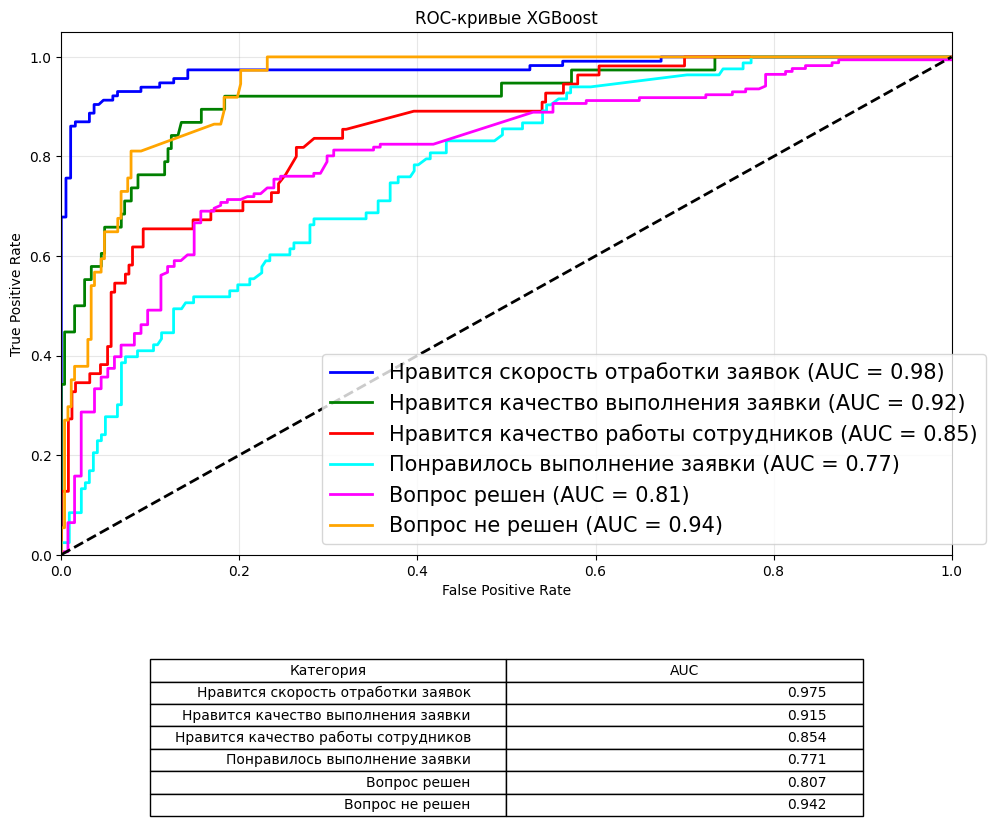

In [ ]:
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange']  # Цвета для каждого класса

# Создаем словарь для хранения метрик
metrics_dict = {}

for i, (col, color) in enumerate(zip(all_tags, colors)):
    # Получаем вероятности для положительного класса
    proba_class_1 = y_pred_proba[i][:, 1]
    
    # Вычисляем ROC-кривую
    fpr, tpr, _ = roc_curve(y_test[:, i], proba_class_1)
    roc_auc = roc_auc_score(y_test[:, i], proba_class_1)
    
    # Сохраняем метрики
    metrics_dict[col] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
    
    # Рисуем кривую
    plt.plot(fpr, tpr, color=color, lw=2,
             label=f'{col} (AUC = {roc_auc:.2f})')

# Добавляем диагональ (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые XGBoost')
plt.legend(loc="lower right", bbox_to_anchor=(1.05, 0), fontsize=15)
plt.grid(True, alpha=0.3)

# Добавляем таблицу с метриками
col_labels = ['Категория', 'AUC']
cell_text = [[k, f'{v["auc"]:.3f}'] for k, v in metrics_dict.items()]
plt.table(cellText=cell_text,
          colLabels=col_labels,
          loc='bottom',
          bbox=[0.1, -0.5, 0.8, 0.3])

plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Делаем место для таблицы

## LogisticRegression

In [19]:

model = MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))
scores = cross_val_score(model, X_tfidf, y, cv=5, scoring='roc_auc')
print(f"ROC-AUC по категориям: {scores}")
print(f"Средний ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

ROC-AUC по категориям: [0.8124806  0.88760769 0.87901202 0.89340857 0.89996209]
Средний ROC-AUC: 0.8745 ± 0.0318


## MLP

In [20]:
mlp_model = MultiOutputClassifier(MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=1000,
    random_state=42,
    early_stopping=True
))

scores = cross_val_score(mlp_model, X_tfidf, y, cv=5, scoring='roc_auc')
print(f"ROC-AUC по категориям: {scores}")
print(f"Средний ROC-AUC: {scores.mean():.4f} ± {scores.std():.4f}")

ROC-AUC по категориям: [0.78128325 0.84129269 0.84870697 0.82882376 0.81044361]
Средний ROC-AUC: 0.8221 ± 0.0242


## Bert & DistilBert

### BERT

In [ ]:
X = tagged_data['comment']  # Текст комментариев
y = tagged_data[all_tags].values  # Метки (0/1)

# Проверка данных
print(tagged_data[all_tags].sum())

# Инициализация токенизатора и модели
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = BertForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels=len(all_tags),  # 5 категорий
    problem_type='multi_label_classification'
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

class CommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание датасетов
train_dataset = CommentDataset(X_train.values, y_train, tokenizer)
test_dataset = CommentDataset(X_test.values, y_test, tokenizer)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Параметры
epochs = 5
optimizer = AdamW(model.parameters(), lr=2e-5)
model.train()

# Обучение
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Average Loss: {total_loss/len(train_loader):.4f}")

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()
        predictions.extend(probs)
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

# ROC-AUC для каждой категории
roc_auc_scores = []
for i, col in enumerate(all_tags):
    roc_auc = roc_auc_score(true_labels[:, i], predictions[:, i])
    roc_auc_scores.append(roc_auc)
    print(f"ROC-AUC для '{col}': {roc_auc:.4f}")

print(f"Средний ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")
# Сохранение модели
model.save_pretrained('bert_model_with_extra_flag')
tokenizer.save_pretrained('bert_token_model_with_extra_flag')

Нравится скорость отработки заявок      623
Нравится качество выполнения заявки     159
Нравится качество работы сотрудников    325
Понравилось выполнение заявки           404
Вопрос решен                            851
Вопрос не решен                         172
dtype: int64


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 77/77 [07:34<00:00,  5.90s/it]


Epoch 1, Average Loss: 0.4925


100%|██████████| 77/77 [07:34<00:00,  5.90s/it]


Epoch 2, Average Loss: 0.3173


100%|██████████| 77/77 [07:32<00:00,  5.88s/it]


Epoch 3, Average Loss: 0.2380


100%|██████████| 77/77 [07:04<00:00,  5.51s/it]


Epoch 4, Average Loss: 0.1881


100%|██████████| 77/77 [07:01<00:00,  5.48s/it]


Epoch 5, Average Loss: 0.1620
ROC-AUC для 'Нравится скорость отработки заявок': 0.9834
ROC-AUC для 'Нравится качество выполнения заявки': 0.8757
ROC-AUC для 'Нравится качество работы сотрудников': 0.9433
ROC-AUC для 'Понравилось выполнение заявки': 0.8232
ROC-AUC для 'Вопрос решен': 0.8941
ROC-AUC для 'Вопрос не решен': 0.9509
Средний ROC-AUC: 0.9118 ± 0.0534


('bert_token_model_with_extra_flag\\tokenizer_config.json',
 'bert_token_model_with_extra_flag\\special_tokens_map.json',
 'bert_token_model_with_extra_flag\\vocab.txt',
 'bert_token_model_with_extra_flag\\added_tokens.json')

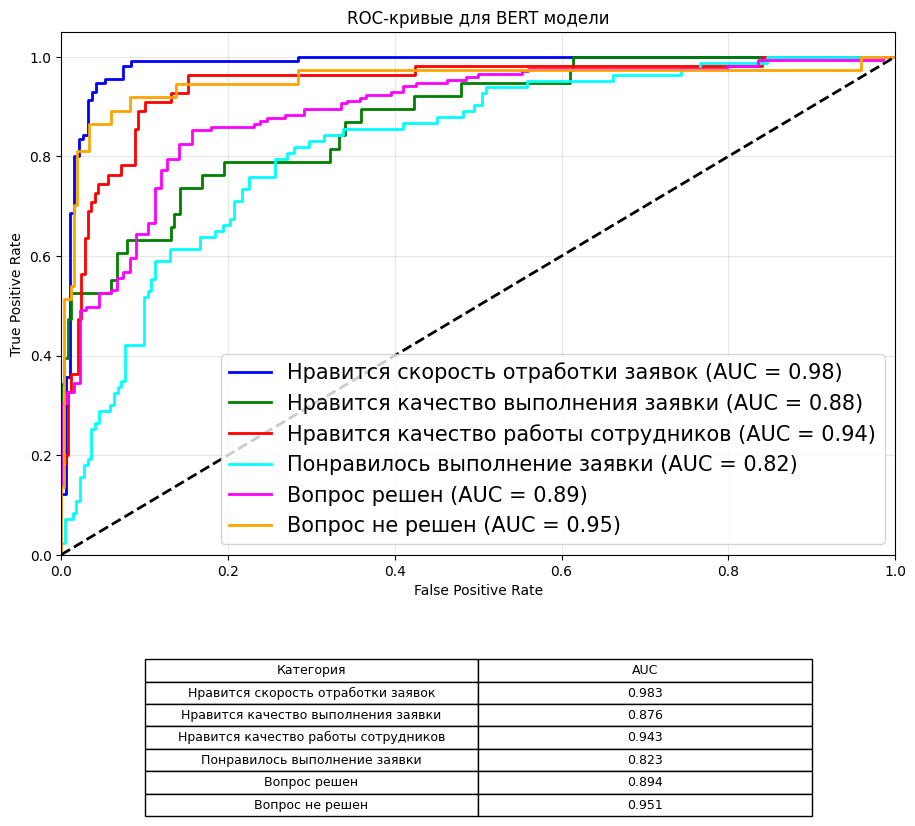

In [40]:

# Создаем график
plt.figure(figsize=(12, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'orange']  # Цвета для каждого класса
metrics_dict = {}

# Вычисляем и рисуем ROC-кривые для каждого класса
for i, (col, color) in enumerate(zip(all_tags, colors)):
    fpr, tpr, _ = roc_curve(true_labels[:, i], predictions[:, i])
    roc_auc = roc_auc_score(true_labels[:, i], predictions[:, i])
    
    metrics_dict[col] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}
    plt.plot(fpr, tpr, color=color, lw=2, label=f'{col} (AUC = {roc_auc:.2f})')

# Добавляем диагональ (random classifier)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для BERT модели')
plt.legend(loc="lower right", bbox_to_anchor=(1, 0), fontsize=15)
plt.grid(True, alpha=0.3)

# Добавляем таблицу с метриками
col_labels = ['Категория', 'AUC']
cell_text = [[k, f'{v["auc"]:.3f}'] for k, v in metrics_dict.items()]
plt.table(cellText=cell_text,
          colLabels=col_labels,
          loc='bottom',
          bbox=[0.1, -0.5, 0.8, 0.3],
          cellLoc='center')

plt.tight_layout()
plt.subplots_adjust(bottom=0.3, right=0.75)  # Регулируем отступы
plt.show()

#### проверка стабильности модели

In [ ]:
from sklearn.model_selection import KFold

tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')

# Dataset
class CommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Параметры
n_folds = 5
epochs = 3  # Уменьшено для скорости, можно вернуть 5
batch_size = 16
max_len = 128
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Кросс-валидация
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_roc_auc_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nФолд {fold+1}/{n_folds}")

    # Разделение данных
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Создание датасетов
    train_dataset = CommentDataset(X_train.values, y_train, tokenizer, max_len)
    val_dataset = CommentDataset(X_val.values, y_val, tokenizer, max_len)

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Инициализация модели
    model = BertForSequenceClassification.from_pretrained(
        'DeepPavlov/rubert-base-cased',
        num_labels=len(all_tags),
        problem_type='multi_label_classification'
    )
    model.to(device)

    # Оптимизатор
    optimizer = AdamW(model.parameters(), lr=2e-5)

    # Обучение
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        print(f"Fold {fold+1}, Epoch {epoch+1}, Average Loss: {total_loss/len(train_loader):.4f}")

    # Оценка на валидационной выборке
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.sigmoid(logits).cpu().numpy()
            predictions.extend(probs)
            true_labels.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)

    # ROC-AUC для фолда
    fold_roc_auc = []
    for i, col in enumerate(all_tags):
        roc_auc = roc_auc_score(true_labels[:, i], predictions[:, i])
        fold_roc_auc.append(roc_auc)
        print(f"Fold {fold+1}, ROC-AUC для '{col}': {roc_auc:.4f}")

    fold_roc_auc_scores.append(fold_roc_auc)
    print(f"Fold {fold+1}, Средний ROC-AUC: {np.mean(fold_roc_auc):.4f} ± {np.std(fold_roc_auc):.4f}")

# Средние результаты по всем фолдам
fold_roc_auc_scores = np.array(fold_roc_auc_scores)
mean_roc_auc = np.mean(fold_roc_auc_scores, axis=0)
std_roc_auc = np.std(fold_roc_auc_scores, axis=0)

for i, col in enumerate(all_tags):
    print(f"Средний ROC-AUC для '{col}': {mean_roc_auc[i]:.4f} ± {std_roc_auc[i]:.4f}")
print(f"Общий средний ROC-AUC: {np.mean(mean_roc_auc):.4f} ± {np.mean(std_roc_auc):.4f}")

# Обучение финальной модели на всех данных
train_dataset = CommentDataset(X.values, y, tokenizer, max_len)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = BertForSequenceClassification.from_pretrained(
    'DeepPavlov/rubert-base-cased',
    num_labels=len(all_tags),
    problem_type='multi_label_classification'
)
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Final Epoch {epoch+1}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Final Epoch {epoch+1}, Average Loss: {total_loss/len(train_loader):.4f}")

# Сохранение модели
model.save_pretrained('bert_model_with_extra_flag')
tokenizer.save_pretrained('bert_token_model_with_extra_flag')


Фолд 1/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 77/77 [00:26<00:00,  2.90it/s]


Fold 1, Epoch 1, Average Loss: 0.5096


Epoch 2: 100%|██████████| 77/77 [00:27<00:00,  2.81it/s]


Fold 1, Epoch 2, Average Loss: 0.3381


Epoch 3: 100%|██████████| 77/77 [00:27<00:00,  2.78it/s]


Fold 1, Epoch 3, Average Loss: 0.2501


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.02it/s]


Fold 1, ROC-AUC для 'Нравится скорость отработки заявок': 0.9791
Fold 1, ROC-AUC для 'Нравится качество выполнения заявки': 0.8000
Fold 1, ROC-AUC для 'Нравится качество работы сотрудников': 0.9490
Fold 1, ROC-AUC для 'Понравилось выполнение заявки': 0.8066
Fold 1, ROC-AUC для 'Вопрос решен': 0.8744
Fold 1, ROC-AUC для 'Вопрос не решен': 0.9621
Fold 1, Средний ROC-AUC: 0.8952 ± 0.0727

Фолд 2/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 77/77 [00:27<00:00,  2.84it/s]


Fold 2, Epoch 1, Average Loss: 0.5159


Epoch 2: 100%|██████████| 77/77 [00:27<00:00,  2.80it/s]


Fold 2, Epoch 2, Average Loss: 0.3604


Epoch 3: 100%|██████████| 77/77 [00:27<00:00,  2.80it/s]


Fold 2, Epoch 3, Average Loss: 0.2714


Validation: 100%|██████████| 20/20 [00:02<00:00,  9.00it/s]


Fold 2, ROC-AUC для 'Нравится скорость отработки заявок': 0.9767
Fold 2, ROC-AUC для 'Нравится качество выполнения заявки': 0.9249
Fold 2, ROC-AUC для 'Нравится качество работы сотрудников': 0.9762
Fold 2, ROC-AUC для 'Понравилось выполнение заявки': 0.8727
Fold 2, ROC-AUC для 'Вопрос решен': 0.8759
Fold 2, ROC-AUC для 'Вопрос не решен': 0.9968
Fold 2, Средний ROC-AUC: 0.9372 ± 0.0495

Фолд 3/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 77/77 [00:27<00:00,  2.83it/s]


Fold 3, Epoch 1, Average Loss: 0.4846


Epoch 2: 100%|██████████| 77/77 [00:27<00:00,  2.81it/s]


Fold 3, Epoch 2, Average Loss: 0.3288


Epoch 3: 100%|██████████| 77/77 [00:27<00:00,  2.81it/s]


Fold 3, Epoch 3, Average Loss: 0.2454


Validation: 100%|██████████| 19/19 [00:02<00:00,  8.53it/s]


Fold 3, ROC-AUC для 'Нравится скорость отработки заявок': 0.9837
Fold 3, ROC-AUC для 'Нравится качество выполнения заявки': 0.8402
Fold 3, ROC-AUC для 'Нравится качество работы сотрудников': 0.9563
Fold 3, ROC-AUC для 'Понравилось выполнение заявки': 0.8037
Fold 3, ROC-AUC для 'Вопрос решен': 0.8898
Fold 3, ROC-AUC для 'Вопрос не решен': 0.9829
Fold 3, Средний ROC-AUC: 0.9094 ± 0.0701

Фолд 4/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 77/77 [00:27<00:00,  2.82it/s]


Fold 4, Epoch 1, Average Loss: 0.4922


Epoch 2: 100%|██████████| 77/77 [00:27<00:00,  2.81it/s]


Fold 4, Epoch 2, Average Loss: 0.3279


Epoch 3: 100%|██████████| 77/77 [00:27<00:00,  2.81it/s]


Fold 4, Epoch 3, Average Loss: 0.2381


Validation: 100%|██████████| 19/19 [00:02<00:00,  8.52it/s]


Fold 4, ROC-AUC для 'Нравится скорость отработки заявок': 0.9834
Fold 4, ROC-AUC для 'Нравится качество выполнения заявки': 0.8850
Fold 4, ROC-AUC для 'Нравится качество работы сотрудников': 0.9715
Fold 4, ROC-AUC для 'Понравилось выполнение заявки': 0.7848
Fold 4, ROC-AUC для 'Вопрос решен': 0.8969
Fold 4, ROC-AUC для 'Вопрос не решен': 0.9755
Fold 4, Средний ROC-AUC: 0.9162 ± 0.0704

Фолд 5/5


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1: 100%|██████████| 77/77 [00:27<00:00,  2.82it/s]


Fold 5, Epoch 1, Average Loss: 0.4849


Epoch 2: 100%|██████████| 77/77 [00:27<00:00,  2.81it/s]


Fold 5, Epoch 2, Average Loss: 0.3206


Epoch 3: 100%|██████████| 77/77 [00:27<00:00,  2.81it/s]


Fold 5, Epoch 3, Average Loss: 0.2418


Validation: 100%|██████████| 19/19 [00:02<00:00,  8.53it/s]


Fold 5, ROC-AUC для 'Нравится скорость отработки заявок': 0.9913
Fold 5, ROC-AUC для 'Нравится качество выполнения заявки': 0.9029
Fold 5, ROC-AUC для 'Нравится качество работы сотрудников': 0.9726
Fold 5, ROC-AUC для 'Понравилось выполнение заявки': 0.8104
Fold 5, ROC-AUC для 'Вопрос решен': 0.8918
Fold 5, ROC-AUC для 'Вопрос не решен': 0.9626
Fold 5, Средний ROC-AUC: 0.9219 ± 0.0616
Средний ROC-AUC для 'Нравится скорость отработки заявок': 0.9828 ± 0.0050
Средний ROC-AUC для 'Нравится качество выполнения заявки': 0.8706 ± 0.0450
Средний ROC-AUC для 'Нравится качество работы сотрудников': 0.9651 ± 0.0106
Средний ROC-AUC для 'Понравилось выполнение заявки': 0.8156 ± 0.0299
Средний ROC-AUC для 'Вопрос решен': 0.8857 ± 0.0090
Средний ROC-AUC для 'Вопрос не решен': 0.9760 ± 0.0131
Общий средний ROC-AUC: 0.9160 ± 0.0187


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Final Epoch 1: 100%|██████████| 96/96 [00:34<00:00,  2.81it/s]


Final Epoch 1, Average Loss: 0.4825


Final Epoch 2: 100%|██████████| 96/96 [00:34<00:00,  2.80it/s]


Final Epoch 2, Average Loss: 0.3125


Final Epoch 3: 100%|██████████| 96/96 [00:34<00:00,  2.81it/s]


Final Epoch 3, Average Loss: 0.2274


('bert_token_model_with_extra_flag/tokenizer_config.json',
 'bert_token_model_with_extra_flag/special_tokens_map.json',
 'bert_token_model_with_extra_flag/vocab.txt',
 'bert_token_model_with_extra_flag/added_tokens.json')

### DistilBert

In [41]:
X = tagged_data['comment']  # Текст комментариев
y = tagged_data[all_tags].values  # Метки (0/1)

# Проверка данных
print(tagged_data[all_tags].sum())

# Инициализация токенизатора и модели
tokenizer = DistilBertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-multilingual-cased',
    num_labels=len(all_tags),
    problem_type='multi_label_classification'
)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

class CommentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание датасетов
train_dataset = CommentDataset(X_train.values, y_train, tokenizer)
test_dataset = CommentDataset(X_test.values, y_test, tokenizer)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Параметры
epochs = 5
optimizer = AdamW(model.parameters(), lr=2e-5)
model.train()

# Обучение
for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Average Loss: {total_loss/len(train_loader):.4f}")

model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.sigmoid(logits).cpu().numpy()
        predictions.extend(probs)
        true_labels.extend(labels.cpu().numpy())

predictions = np.array(predictions)
true_labels = np.array(true_labels)

# ROC-AUC для каждой категории
roc_auc_scores = []
for i, col in enumerate(all_tags):
    roc_auc = roc_auc_score(true_labels[:, i], predictions[:, i])
    roc_auc_scores.append(roc_auc)
    print(f"ROC-AUC для '{col}': {roc_auc:.4f}")

print(f"Средний ROC-AUC: {np.mean(roc_auc_scores):.4f} ± {np.std(roc_auc_scores):.4f}")


Нравится скорость отработки заявок      623
Нравится качество выполнения заявки     159
Нравится качество работы сотрудников    325
Понравилось выполнение заявки           404
Вопрос решен                            851
Вопрос не решен                         172
dtype: int64


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'DistilBertTokenizer'.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 77/77 [03:37<00:00,  2.82s/it]


Epoch 1, Average Loss: 0.5442


100%|██████████| 77/77 [03:32<00:00,  2.76s/it]


Epoch 2, Average Loss: 0.4499


100%|██████████| 77/77 [03:32<00:00,  2.75s/it]


Epoch 3, Average Loss: 0.3730


100%|██████████| 77/77 [03:31<00:00,  2.74s/it]


Epoch 4, Average Loss: 0.3117


100%|██████████| 77/77 [03:32<00:00,  2.76s/it]


Epoch 5, Average Loss: 0.2589
ROC-AUC для 'Нравится скорость отработки заявок': 0.9627
ROC-AUC для 'Нравится качество выполнения заявки': 0.8532
ROC-AUC для 'Нравится качество работы сотрудников': 0.8384
ROC-AUC для 'Понравилось выполнение заявки': 0.7473
ROC-AUC для 'Вопрос решен': 0.7697
ROC-AUC для 'Вопрос не решен': 0.8670
Средний ROC-AUC: 0.8397 ± 0.0701


['distilbert_model.pkl']